In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import datetime
import os
from sklearn.metrics import mean_squared_error
test_symbols = ["CTXR", "IBIO", "MNKD", "IMGN", "ATOS", "SPPI"]
model_settings = {'epochs': 1000, 'batch_size': 100, 'train_test_ratio': 0.7, 'hidden_layers': 3, 'units': 100}

# Choose what Symbol you would like to predict:
symbol = 'CTXR'     # change to whatever symbol in your dataframe you'd like to attempt to predict.
start_date = "2020-01-01"
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_settings['start_date'] = start_date
model_settings['end_date'] = current_date

# next cell
conn = sqlite3.connect('stockPrediction_05262021.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{symbol}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

# next
# reset the index
df = df.reset_index()

# next
# convert to datetime
df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

# reshape
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[start_date:current_date]  # date range from 2019-01-01 to 2021-05-31

# set a threshold of how many np.nan you are willing to work with
close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

# forward fill in np.nan values in columns not previously dropped.
close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)



In [2]:
# splitting test/training data
data_size = len(close_df)

# using a 90/10 train/test split
training_data = close_df.iloc[:(int(data_size * model_settings['train_test_ratio']))]
test_data = close_df.iloc[(int(data_size * model_settings['train_test_ratio'])):]

# First, create a singular dataframe from the symbol you would like to predict vaues for
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()

minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)

train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))



In [3]:
# prep test data early, so I can get validation loss info?
# next part may not be necessary:
total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
# print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

In [4]:
# TRAINING THE MODEL

# LSTM architecture
regressor = tf.keras.Sequential()

# First layer, w/ dropout regularization
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(tf.keras.layers.Dropout(0.2))

# Second
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

# Third
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.5))

# Fourth
regressor.add(tf.keras.layers.LSTM(units=model_settings['units']))
regressor.add(tf.keras.layers.Dropout(0.5))

# Output layer
regressor.add(tf.keras.layers.Dense(units=1))

# Compile LSTM
regressor.compile(optimizer='adam', loss='mean_squared_error')



In [5]:
# Fit to Training set
# fit to training set
# TBH I don't really understand why we iterate over the columns for this training; 
# we're not changing the data that gets fed to the model in these iterations, we're just repeating it
# going to comment this part out, just try doing it once
'''num_features = len(training_data.columns)
progress = 1
for i in training_data.columns:
    print("Fitting to", i)
    print("Training feature", progress, "of", num_features)
    regressor.fit(X_train, y_train, epochs=model_settings['epochs'], batch_size=model_settings['batch_size'], verbose=0)
    progress += 1'''

print("training model...")
regressor.fit(X_train, y_train, epochs=model_settings['epochs'], batch_size=model_settings['batch_size'], verbose=0, validation_data=(X_test, y_test), shuffle=True)

print("Saving Model...")
regressor.save(f"model_{current_datetime}")
print("Model Saved.")



training model...
Saving Model...
INFO:tensorflow:Assets written to: model_20210626_140143\assets
INFO:tensorflow:Assets written to: model_20210626_140143\assets
Model Saved.


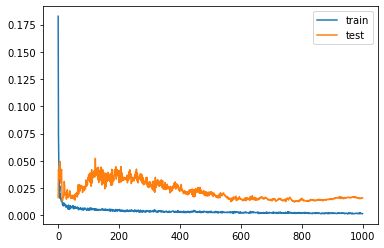

In [6]:
plt.plot(regressor.history.history['loss'], label='train')
plt.plot(regressor.history.history['val_loss'], label='test')
plt.legend()

<ipython-input-7-83bc726bc5f1>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mse_values = pd.Series()
Shape of test data: (166, 412)
Shape of test data: (166, 412)
Shape of test data: (166, 412)
Shape of test data: (166, 412)
Shape of test data: (166, 412)
Shape of test data: (166, 412)


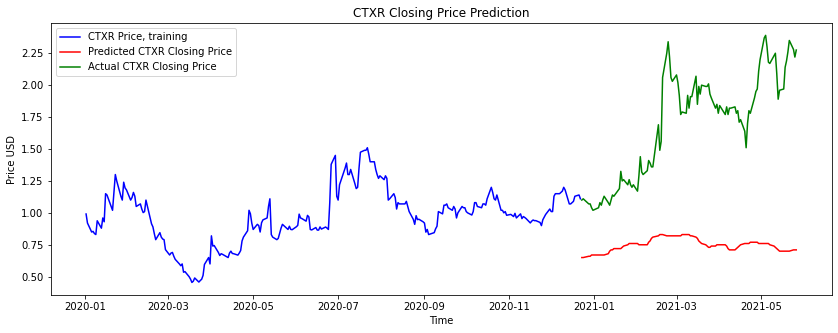

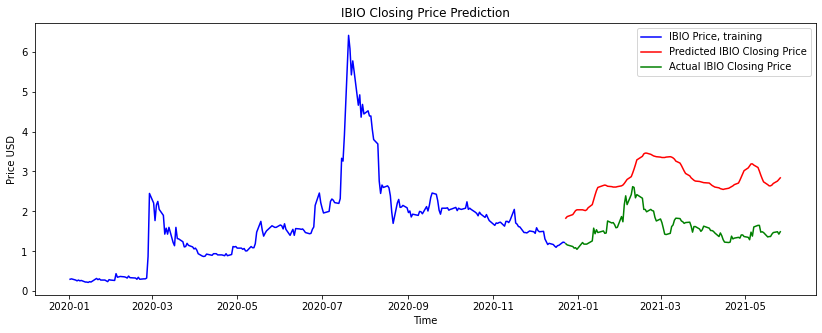

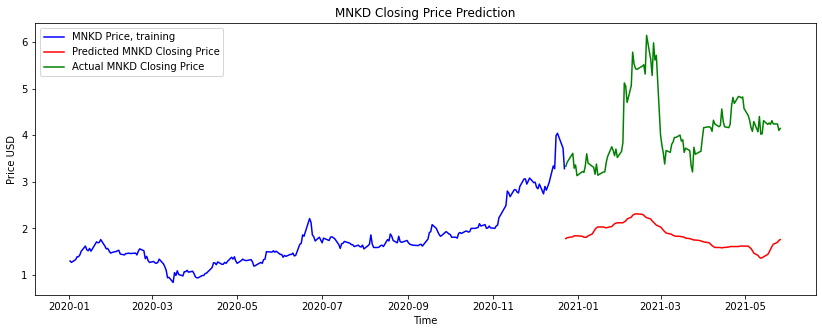

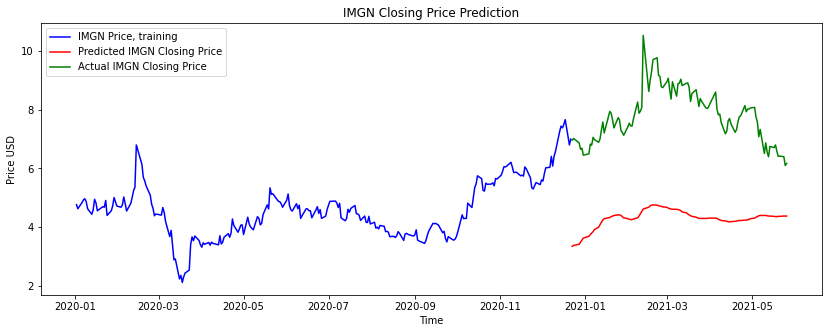

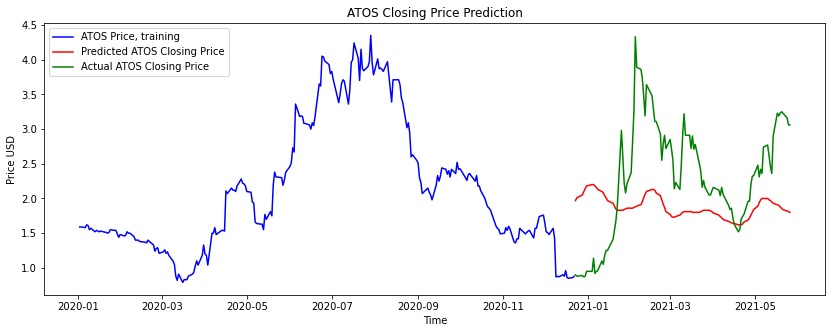

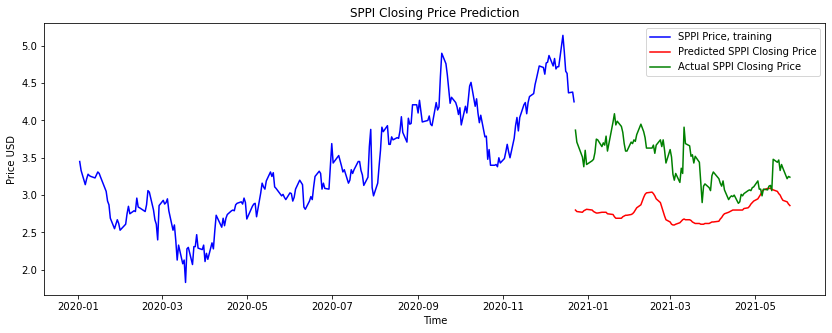

In [7]:
# next part may not be necessary:
total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
# print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=2)
predicted_price.index = test_data.index     # end of possibly not necessary code

# now onto the test

directory = f"test_plots_{current_datetime}"
parent_dir = r"C:\Users\james\Dropbox\Box Sync\code\stockPrediction"

path = os.path.join(parent_dir, directory)
os.mkdir(path)

mse_values = pd.Series()
model_settings_pd = pd.Series(model_settings)
model_settings_pd.to_csv(f"{path}/{current_datetime}_model_settings.csv")

for symbol in test_symbols:
    # First, create a singular dataframe from the symbol you would like to predict vaues for
    training_data_predicted = training_data[symbol]
    training_data_predicted = training_data_predicted.to_frame()

    minmax = MinMaxScaler(feature_range=(0,1))
    minmax_single = MinMaxScaler(feature_range=(0,1))

    # Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
    training_data = training_data.drop(columns=symbol)
    train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

    columns = [i for i in training_data.columns]
    columns.append(symbol)

    # I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
    training_data[symbol] = training_data_predicted[symbol]

    train_scaled = pd.DataFrame(train_scaled, columns=columns)

    # this section may not be necessary
    train_scaled = train_scaled.values
    n_lags = int(60) # not sure why hard 60
    X_train = []
    y_train = []
    for i in range(n_lags, train_scaled.shape[0]):
        X_train.append(train_scaled[i-n_lags:i])
        y_train.append(train_scaled[i,0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

    # this may also not be necessary

    total_data = pd.concat((training_data, test_data), axis=0)
    inputs = total_data[len(total_data) - len(test_data) - 60:]
    # inputs = data[len(data) - len(test_data) - 60:]

    predicted_input = inputs[symbol].to_frame()
    inputs = inputs.drop(columns=symbol)

    test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
    print('Shape of test data:', test_scaled.shape)

    # shaping test data from neural network
    X_test = []
    y_test = []
    for i in range(60, test_scaled.shape[0]):
        X_test.append(test_scaled[i-n_lags:i])
        y_test.append(test_scaled[i,0])

    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

    # this part is absolutely necessary
    predicted_price = regressor.predict(X_test)
    predicted_price = minmax_single.inverse_transform(predicted_price)
    predicted_price = pd.DataFrame(predicted_price)
    predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
    predicted_price = predicted_price.round(decimals=2)
    predicted_price.index = test_data.index

    # plot
    plt.figure(figsize=(14,5))
    #mse = mean_squared_error(y_test, predicted_price)
    plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
    plt.plot(predicted_price[f'{symbol}_predicted'], color = 'red', label= f'Predicted {symbol} Closing Price')
    plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
    # plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
    plt.title(f'{symbol} Closing Price Prediction')
    plt.xlabel("Time")
    plt.ylabel('Price USD')
    plt.legend()
    plt.savefig(f"{path}/{symbol}_{current_datetime}")

    mse = mean_squared_error(test_data[symbol], predicted_price[f'{symbol}_predicted'])
    mse_values[symbol] = mse

mse_values.to_csv(f"{path}/{current_datetime}_mse.csv")

In [5]:
# place the symbol you'd like to predict in here
symbol = 'ACER'

# first, we need to redo our training/test data sets to predict accurately
# otherwise, we are scaling one symbol based on another
# we start w/ the pre-training code that prepares the data

# First, create a singular dataframe from the symbol you would like to predict vaues for
# We need to create this df separate from the other df, so that we can feed a single symbol's data into the scaler when making predictions
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()

minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)

# reshape data into an np.array
train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
# shape of len, sequence, features
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

# now, reshaping data for testing based on training data

total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))



Shape of test data: (166, 412)


In [6]:
# this part is absolutely necessary
predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=2)
predicted_price.index = test_data.index

# plot
plt.figure(figsize=(14,5))
#mse = mean_squared_error(y_test, predicted_price)
plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
plt.plot(predicted_price[f'{symbol}_predicted'], color = 'red', label= f'Predicted {symbol} Closing Price')
plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
# plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
plt.title(f'{symbol} Closing Price Prediction')
plt.xlabel("Time")
plt.ylabel('Price USD')
plt.legend()

KeyboardInterrupt: 

# Predictions from all data, no tests to verify, start below

In [1]:
# import, prep data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import datetime
import os
from sklearn.metrics import mean_squared_error
test_symbols = ["CTXR", "IBIO", "MNKD", "IMGN", "ATOS", "SPPI"]
model_settings = {'epochs': 100, 'batch_size': 100, 'train_test_ratio': 0.7, 'hidden_layers': 3, 'units': 100}

# Choose what Symbol you would like to predict:
symbol = 'CTXR'     # change to whatever symbol in your dataframe you'd like to attempt to predict.
start_date = "2020-01-01"
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_settings['start_date'] = start_date
model_settings['end_date'] = current_date

# next cell
conn = sqlite3.connect('stockPrediction_05262021.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{symbol}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

# next
# reset the index
df = df.reset_index()

# next
# convert to datetime
df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

# reshape
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[start_date:current_date]  # date range from 2019-01-01 to 2021-05-31

# set a threshold of how many np.nan you are willing to work with
close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

# forward fill in np.nan values in columns not previously dropped.
close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)



In [2]:
# splitting test/training data
data_size = len(close_df)

# training_data = close_df.iloc[:(int(data_size * model_settings['train_test_ratio']))]
# test_data = close_df.iloc[(int(data_size * model_settings['train_test_ratio'])):]
training_data = close_df

# First, create a singular dataframe from the symbol you would like to predict vaues for
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()

minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# scale data
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)

train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))



In [3]:
# TRAINING THE MODEL

# LSTM architecture
regressor = tf.keras.Sequential()

# First layer, w/ dropout regularization
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(tf.keras.layers.Dropout(0.2))

# Second
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

# Third
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.5))

# Fourth
regressor.add(tf.keras.layers.LSTM(units=model_settings['units']))
regressor.add(tf.keras.layers.Dropout(0.5))

# Output layer
# based on other tutorials, setting Dense units to # of days outward I would like to predict
regressor.add(tf.keras.layers.Dense(units=1))

# Compile LSTM
regressor.compile(optimizer='adam', loss='mean_squared_error')



In [4]:
print("training model...")
regressor.fit(X_train, y_train, epochs=model_settings['epochs'], batch_size=model_settings['batch_size'], verbose=1)

print("Saving Model...")
# regressor.save(f"model_{current_datetime}")
print("Model Saved.")

training model...
Epoch 1/100
3/3 [==============================] - 5s 29ms/step - loss: 0.1289
Epoch 2/100
3/3 [==============================] - 0s 30ms/step - loss: 0.0898
Epoch 3/100
3/3 [==============================] - 0s 29ms/step - loss: 0.0451
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0262
Epoch 5/100
3/3 [==============================] - 0s 27ms/step - loss: 0.0221
Epoch 6/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0201
Epoch 7/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0150
Epoch 8/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0137
Epoch 9/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0102
Epoch 10/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0110
Epoch 11/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0098
Epoch 12/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0099
Epoch 13/100
3/3 [=============

In [5]:
# shape data to predict w/ 
'''# First, create a singular dataframe from the symbol you would like to predict vaues for
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()

minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)

# this section may not be necessary
train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

# this may also not be necessary'''

total_data = training_data
# inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = total_data[len(total_data) - 60:]
inputs = total_data
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))



Shape of test data: (353, 412)


In [6]:
# this will require some manually debugging, I'm sure of it

# this part is absolutely necessary
predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=2)
# predicted_price.index = test_data.index



In [43]:
predicted_price

,CTXR_predicted,price_datetime
0,1.27,2021-05-27
1,1.25,2021-05-28
2,1.24,2021-05-31
3,1.23,2021-06-01
4,1.22,2021-06-02
...,...,...
581,NaN,2022-07-05
582,NaN,2022-07-06
583,NaN,2022-07-07
584,NaN,2022-07-08


In [8]:
total_data = total_data.reset_index()
for i in range(len(predicted_price)):
    try:
        future_date = predicted_price['price_datetime'].iloc[i -1] + datetime.timedelta(days=1)
    except:
        future_date = total_data.price_datetime.iloc[-1] + datetime.timedelta(days=1)
    
    while future_date.weekday() in [5,6]:
        future_date = future_date + datetime.timedelta(days=1)
    future_date = future_date.strftime('%Y-%m-%d')
    future_date = pd.to_datetime(future_date, format='%Y-%m-%d')
    future_dates = {'price_datetime': future_date}
    '''try:
        future_dates_df = future_dates_df.append(future_dates, ignore_index=True)
    except:
        future_dates_df = pd.DataFrame.from_dict(future_dates)'''
    predicted_price = predicted_price.append(future_dates, ignore_index=True)
    predicted_price['price_datetime'].iloc[i] = future_date
# predicted_price['price_datetime'] = future_dates_df['price_datetime']


C:\Users\james\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [9]:
predicted_price = predicted_price.set_index('price_datetime')
predicted_price = predicted_price.dropna()
predicted_price

,CTXR_predicted
price_datetime,
2021-05-27,1.08
2021-05-28,1.09
2021-05-31,1.11
2021-06-01,1.13
2021-06-02,1.15
...,...
2022-07-05,0.72
2022-07-06,0.73
2022-07-07,0.74


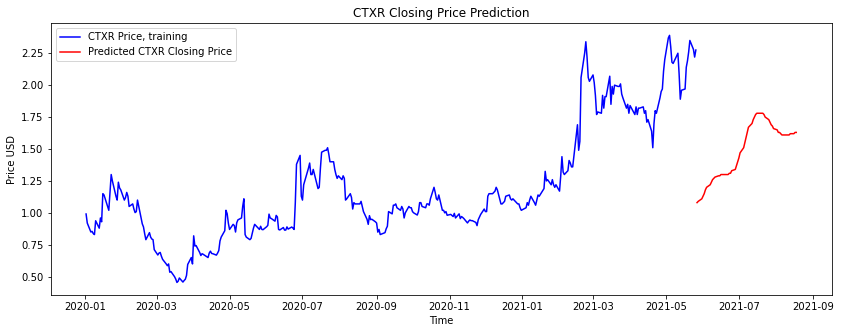

In [10]:
# plot
plt.figure(figsize=(14,5))
#mse = mean_squared_error(y_test, predicted_price)
plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
plt.plot(predicted_price[f'{symbol}_predicted'].iloc[:60], color = 'red', label= f'Predicted {symbol} Closing Price')
# plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
# plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
plt.title(f'{symbol} Closing Price Prediction')
plt.xlabel("Time")
plt.ylabel('Price USD')
plt.legend()
# plt.savefig(f"{path}/{symbol}_{current_datetime}")

# mse = mean_squared_error(test_data[symbol], predicted_price[f'{symbol}_predicted'])
# print('MSE for ', symbol, mse)
# mse_values[symbol] = mse

# mse_values.to_csv(f"{path}/{current_datetime}_mse.csv")

Shape of test data: (353, 412)
C:\Users\james\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
Shape of test data: (353, 412)
C:\Users\james\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
Shape of test data: (353, 412)
C:\Users\james\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

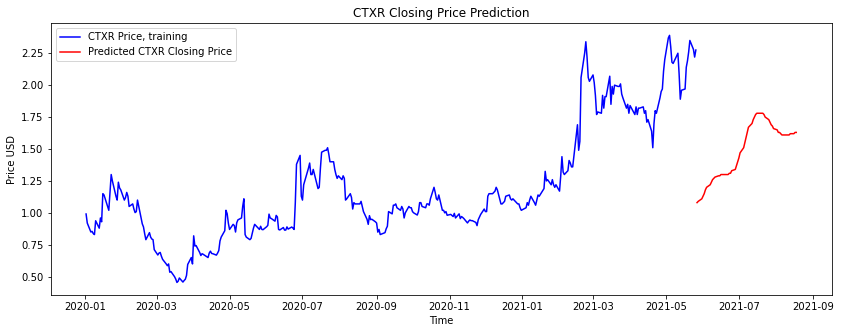

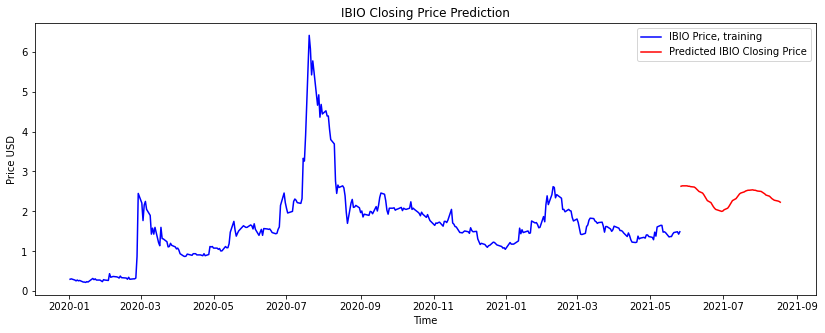

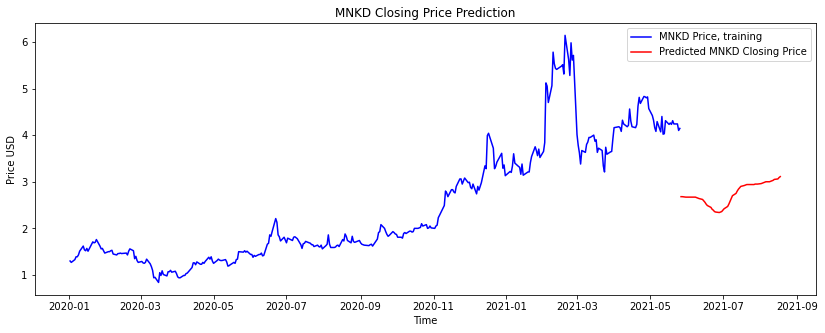

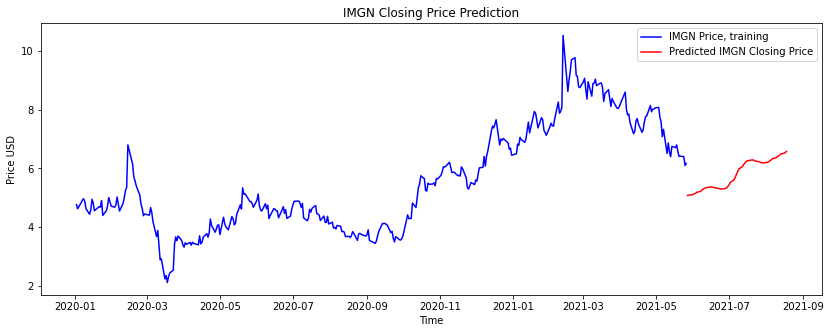

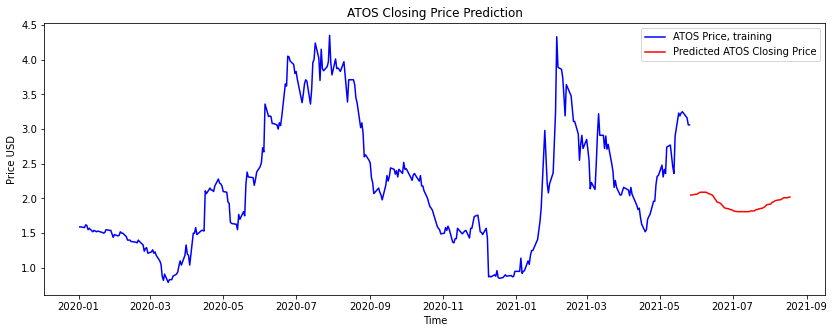

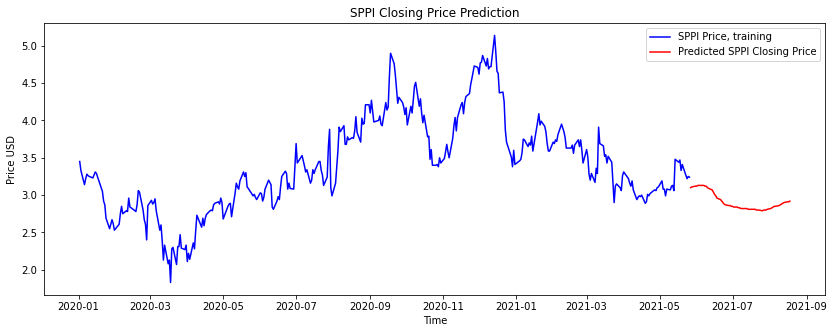

In [11]:
# test loop to look at some various symbols and make predictions
# not complete really, just to kinda see what happens
for symbol in test_symbols:
    # shape data to predict w/ 
    # First, create a singular dataframe from the symbol you would like to predict vaues for
    training_data_predicted = training_data[symbol]
    training_data_predicted = training_data_predicted.to_frame()

    minmax = MinMaxScaler(feature_range=(0,1))
    minmax_single = MinMaxScaler(feature_range=(0,1))

    # Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
    training_data = training_data.drop(columns=symbol)
    train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

    columns = [i for i in training_data.columns]
    columns.append(symbol)

    # I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
    training_data[symbol] = training_data_predicted[symbol]

    train_scaled = pd.DataFrame(train_scaled, columns=columns)

    # this section may not be necessary
    train_scaled = train_scaled.values
    n_lags = int(60) # not sure why hard 60
    X_train = []
    y_train = []
    for i in range(n_lags, train_scaled.shape[0]):
        X_train.append(train_scaled[i-n_lags:i])
        y_train.append(train_scaled[i,0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

    # this may also not be necessary

    total_data = training_data
    # inputs = total_data[len(total_data) - len(test_data) - 60:]
    # inputs = total_data[len(total_data) - 60:]
    inputs = total_data
    # inputs = data[len(data) - len(test_data) - 60:]

    predicted_input = inputs[symbol].to_frame()
    inputs = inputs.drop(columns=symbol)

    test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
    print('Shape of test data:', test_scaled.shape)

    # shaping test data from neural network
    X_test = []
    y_test = []
    for i in range(60, test_scaled.shape[0]):
        X_test.append(test_scaled[i-n_lags:i])
        y_test.append(test_scaled[i,0])

    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

    # this will require some manually debugging, I'm sure of it

    # this part is absolutely necessary
    predicted_price = regressor.predict(X_test)
    predicted_price = minmax_single.inverse_transform(predicted_price)
    predicted_price = pd.DataFrame(predicted_price)
    predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
    predicted_price = predicted_price.round(decimals=2)
    # predicted_price.index = test_data.index

    total_data = total_data.reset_index()
    for i in range(len(predicted_price)):
        try:
            future_date = predicted_price['price_datetime'].iloc[i -1] + datetime.timedelta(days=1)
        except:
            future_date = total_data.price_datetime.iloc[-1] + datetime.timedelta(days=1)
        
        while future_date.weekday() in [5,6]:
            future_date = future_date + datetime.timedelta(days=1)
        future_date = future_date.strftime('%Y-%m-%d')
        future_date = pd.to_datetime(future_date, format='%Y-%m-%d')
        future_dates = {'price_datetime': future_date}
        '''try:
            future_dates_df = future_dates_df.append(future_dates, ignore_index=True)
        except:
            future_dates_df = pd.DataFrame.from_dict(future_dates)'''
        predicted_price = predicted_price.append(future_dates, ignore_index=True)
        predicted_price['price_datetime'].iloc[i] = future_date
    # predicted_price['price_datetime'] = future_dates_df['price_datetime']
    # this is so that when looping this code it doesn't cause problems
    total_data = total_data.set_index('price_datetime')

    predicted_price = predicted_price.set_index('price_datetime')
    predicted_price = predicted_price.dropna()

    plt.figure(figsize=(14,5))
    #mse = mean_squared_error(y_test, predicted_price)
    plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
    plt.plot(predicted_price[f'{symbol}_predicted'].iloc[:60], color = 'red', label= f'Predicted {symbol} Closing Price')
    # plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
    # plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
    plt.title(f'{symbol} Closing Price Prediction')
    plt.xlabel("Time")
    plt.ylabel('Price USD')
    plt.legend()

